# Análise de Jogos

Você faz parte da equipe da loja online Ice, que realiza vendas de videogames em todo o mundo. No contexto desse projeto, nosso objetivo é analisar avaliações de usuários e especialistas, bem como informações sobre gêneros, plataformas (como Xbox ou PlayStation) e dados históricos de vendas de jogos, todos disponíveis em fontes públicas. A finalidade principal é identificar padrões que possam predizer o sucesso de um jogo, o que nos permitirá reconhecer potenciais títulos de destaque e planejar campanhas de marketing mais eficazes.

Os dados disponíveis abrangem o período até 2016, e estamos atualmente em dezembro desse ano, preparando nossa estratégia de campanha para 2017. O conjunto de dados inclui a classificação ESRB (Entertainment Software Rating Board), que avalia o conteúdo dos jogos e atribui uma classificação etária, como "Adolescente" ou "Maduro".

## Iniciação

In [1]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
from functools import reduce
import math
import matplotlib.pyplot as plt

## Carregando dados

In [2]:
try:
    data = pd.read_csv('games.csv')
except:
    data = pd.read_csv('/datasetes/games.csv')

## Obtendo informações gerais e cuidando de valores

In [3]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Observando os dados notamos os seguintes pontos:
- A coluna `Year_of_Release` com o tipo `float` ao invés de `int` ou `datetime`;
- `Genre` e `Name` possui 2 valores ausentes;
- `Critic_Score` possui a maior quantidade de valores ausentes entre as colunas;
- `User_Score` como `object` ao invés de `float`;
- `Rating` também com valores ausentes;
- As colunas estão com os nomes errados, portanto, serão convertidas para `lowercase`.

In [4]:
data.columns = map(str.lower, data.columns)

data = data[data.name.notnull()] #exclui as linhas com nomes nulos e, portanto, os gêneros também

year_mapper = data.groupby('platform')['year_of_release'].median().to_dict()

def year_fill(row):
    if np.isnan(row['year_of_release']):
        return year_mapper.get(row['platform'])
    return row['year_of_release']

data['year_of_release'] = data.apply(year_fill, axis=1)
data['year_of_release'] = data['year_of_release'].astype('Int16')

c_score_mapper = data.groupby('genre')['critic_score'].median().to_dict()

def c_score_fill(row):
    if np.isnan(row['critic_score']):
        return c_score_mapper.get(row['genre'])        
    return row['critic_score'] 
data['critic_score'] = data.apply(c_score_fill, axis=1)

data['user_score'] = data['user_score'].apply(pd.to_numeric, errors='coerce')
data['user_score'] = data['user_score'].fillna(data['user_score'].mean())

rating_mapper = data.groupby('genre')['rating'].agg(pd.Series.mode).to_dict()

def rating_fill(row):
    if pd.isna(row['rating']):
        return rating_mapper.get(row['genre'])
    return row['rating']

data['rating'] = data.apply(rating_fill, axis=1)

data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales']

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  Int16  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  float64
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
 11  total_sales      16713 non-null  float64
dtypes: Int16(1), float64(7), object(4)
memory usage: 1.6+ MB


## Analizando os dados

### Jogos lançados por ano

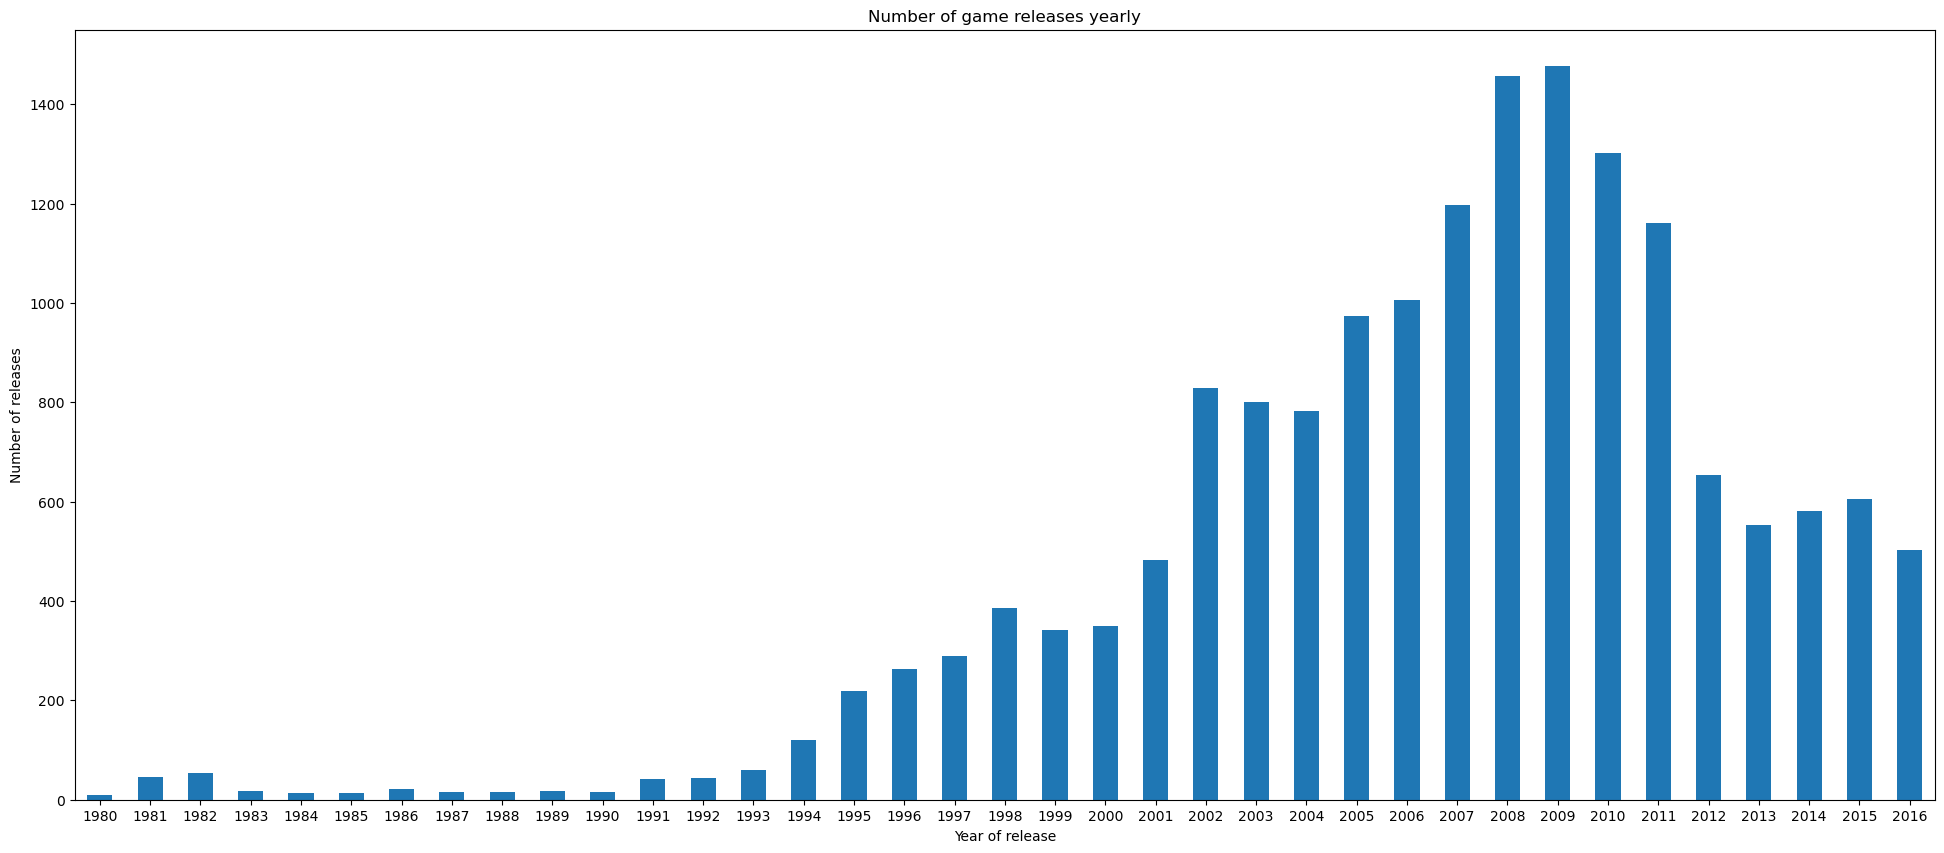

In [5]:
year_count = data.groupby('year_of_release')['name'].count()

year_count.plot.bar(rot=0, figsize=(24, 10))
plt.title('Number of game releases yearly')
plt.xlabel('Year of release')
plt.ylabel('Number of releases')
plt.show()

Notamos que entre os anos de 1980 e 1995 foram lançados menos de 200 jogos por ano tornando-se popular a partir de 1995 no qual o número de lançamentos aumentou exponencialmente até 2009 quando alcançou seu pico com mais de 1400 lançamentos por ano.

### Duração de vendas da plataforma

In [6]:
platforms_grouped = data.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales', ascending=False)
platforms_grouped.head()

,total_sales
platform,
PS2,1062.33
X360,885.66
Wii,828.44
PS3,803.97
DS,746.86


Text(0.5, 1.0, 'PS3 - year_of_release')

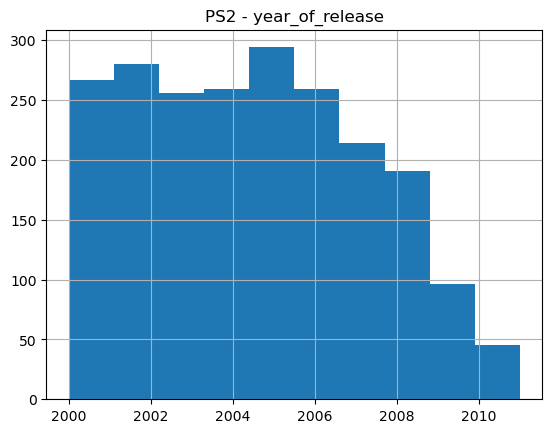

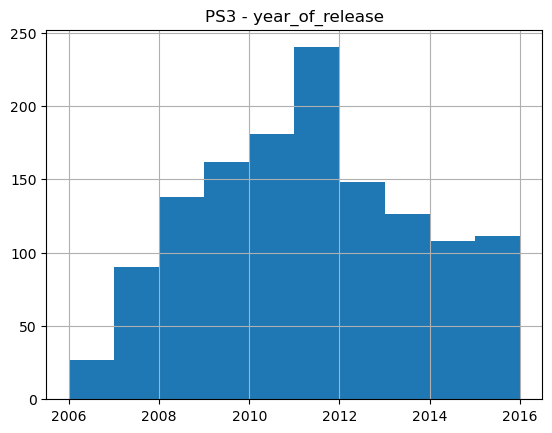

In [7]:
ps2_data = data.query('platform == "PS2"')
ps3_data = data.query('platform == "PS3"')

ps2_data.hist('year_of_release')
plt.title('PS2 - year_of_release')

ps3_data.hist('year_of_release')
plt.title('PS3 - year_of_release')

Observamos nos histogramas que, o console PS2 permaneceu relevante por aproximadamente 10 anos antes de finalmente desaparecer. Podemos notar uma semelhança entre os dois gráficos considerando que demorou aproximadamente 4 anos entre os anos de 2006-2010 para o PS3 substituir totalmente o PS2. Os jogos lançados para o PS2 diminuíram lentamente e os jogos lançados para o PS3 aumentaram lentamente.

### Dados de 2016

In [8]:
recent_data = data[data['year_of_release'] == 2016]
recent_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.000000,E,6.49
108,Pokemon Sun/Moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,74.0,7.125046,T,6.69
171,Uncharted 4: A Thief's End,PS4,2016,Shooter,1.85,2.50,0.19,0.85,93.0,7.900000,T,4.54
245,Call of Duty: Infinite Warfare,PS4,2016,Shooter,1.61,2.00,0.15,0.71,77.0,3.400000,M,3.76
289,Battlefield 1,PS4,2016,Shooter,1.10,2.15,0.21,0.61,88.0,8.400000,M,3.46


### Lideres de vendas de 2016

In [9]:
recent_grouped = recent_data.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales', ascending=False)
recent_grouped.head()

,total_sales
platform,
PS4,59.01
XOne,23.91
3DS,14.50
PC,4.89
WiiU,4.25


O PS4 teve a maior quantidade de vendas em 2016 comparado com os outros consoles no mesmo período.

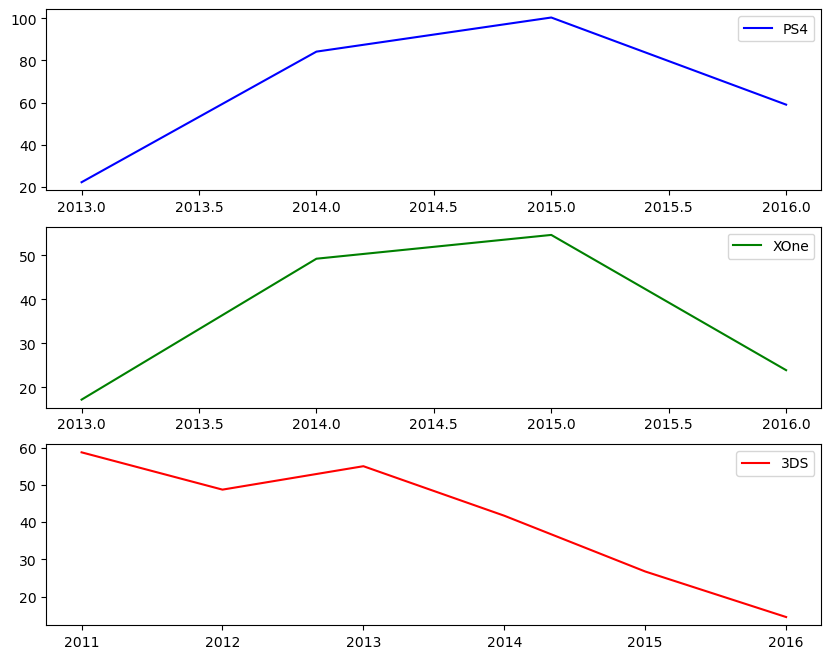

In [10]:
ps4_trend = data[data['platform'] == 'PS4'].groupby('year_of_release').agg({'total_sales':'sum'}).reset_index()
xone_trend = data[data['platform'] == 'XOne'].groupby('year_of_release').agg({'total_sales':'sum'}).reset_index()
ds_trend = data[data['platform'] == '3DS'].groupby('year_of_release').agg({'total_sales':'sum'}).reset_index()

fig, ax = plt.subplots(3, 1, figsize=(10,8))

ax[0].plot(ps4_trend['year_of_release'], ps4_trend['total_sales'], color='blue')
ax[0].legend(["PS4"])

ax[1].plot(xone_trend['year_of_release'], xone_trend['total_sales'], color='green')
ax[1].legend(["XOne"])

ax[2].plot(ds_trend['year_of_release'], ds_trend['total_sales'], color='red')
ax[2].legend(["3DS"])

plt.show()

O gráfico mostra uma queda nas vendas em 2016 em várias plataformas, portanto, conclui-se que fatores externos contribuiram para a queda nas vendas. No entanto, o console PS4 ainda obteve o maior lucro total e, consequentemente, seu gráfico difere em muito o do 3DS. Com base nisso, o PS4 foi escolhido como a plataforma de escolha.

{'whiskers': [<matplotlib.lines.Line2D at 0x177c5f48a60>,
 'caps': [<matplotlib.lines.Line2D at 0x177c5f5a040>,
 'boxes': [<matplotlib.lines.Line2D at 0x177c5f48790>,
 'medians': [<matplotlib.lines.Line2D at 0x177c5f5a5e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x177c5f5a8b0>,
 'means': []}

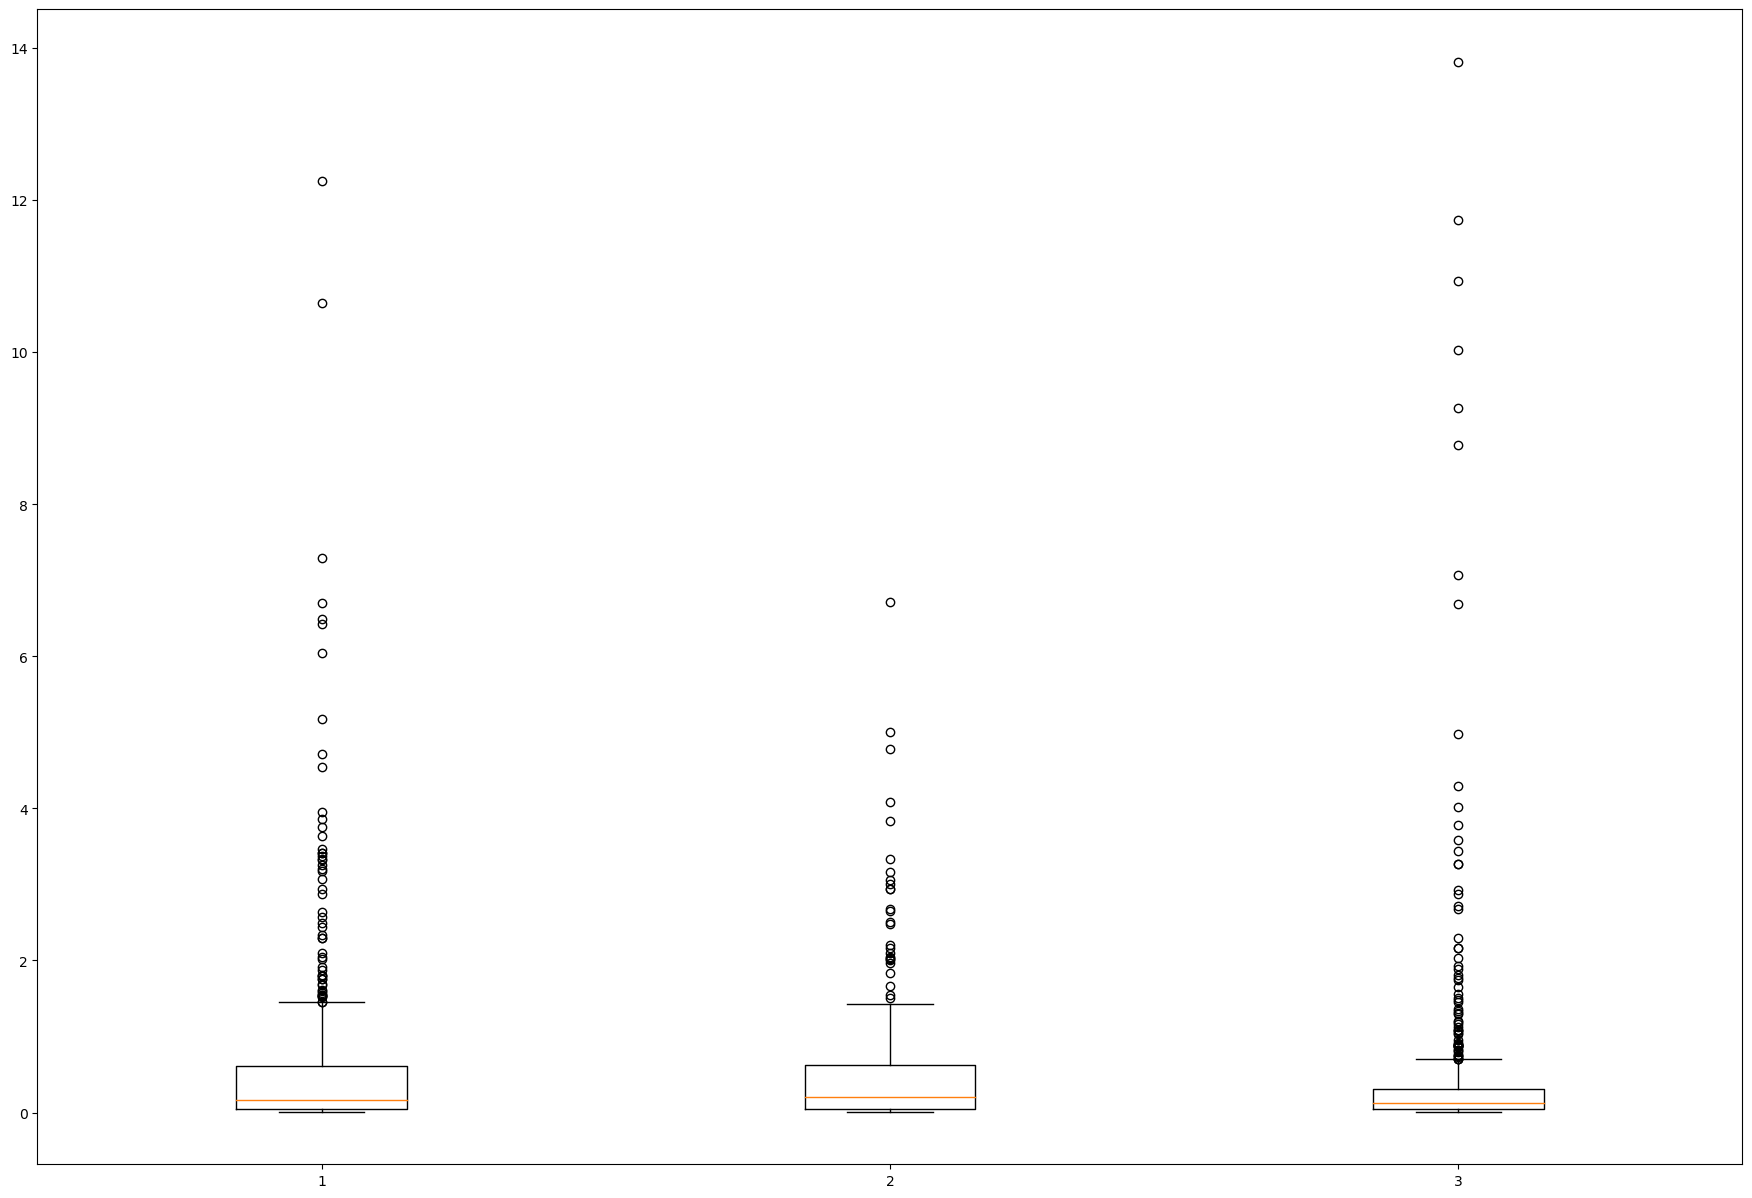

In [11]:
ps4_data = data.query('platform == "PS4"')
xone_data = data.query('platform == "XOne"')
ds_data = data.query('platform == "3DS"')

plt.figure(figsize=(22, 15))
plt.boxplot([ps4_data['total_sales'], xone_data['total_sales'], ds_data['total_sales']])


Abaixo, o mesmo será apresentado sem os outliers.

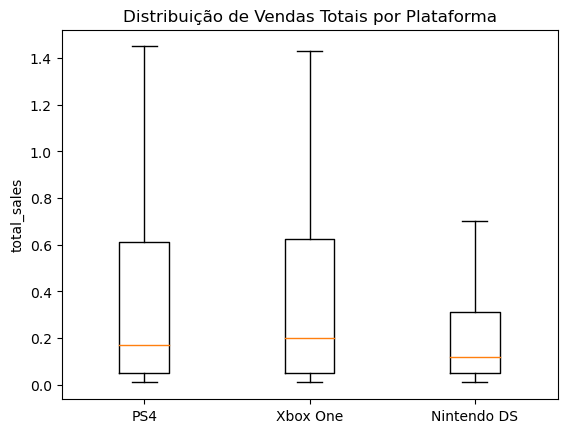

In [12]:
plt.boxplot([ps4_data['total_sales'], xone_data['total_sales'], ds_data['total_sales']], showfliers=False)

plt.xticks([1, 2, 3], ['PS4', 'Xbox One', 'Nintendo DS'])
plt.ylabel('total_sales')

plt.title('Distribuição de Vendas Totais por Plataforma')
plt.show()

Acima observamos uma comparação entre o PS3, Xbox One e 3DS para o ano de 2016. A distribuição das vendas totais de cada jogo entre PS4 e Xbox One são bastante semelhantes. O PS4, no entanto, tem significativamente mais outliers, alguns com vendas totais muito maiores do que os outliers do Xbox One. O 3DS tem outliers de vendas totais maiores do que o PS4, todavia, vemos claramente no segundo gráfico que o IQR do 3DS é consideravelmente menor do que os outros consoles e a mediana é a mais baixa dos três. Os bigodes são similares no PS4 e no Xbox One, e os IQRs e a mediana são quase os mesmos. Pelas distribuições, o Xbox One ainda é uma escolha boa como plataforma para lançar um jogo, apesar de possuir o menor outlier.

### Feedback relacionado ao PS4

,user_score,total_sales
user_score,1.000000,-0.044788
total_sales,-0.044788,1.000000


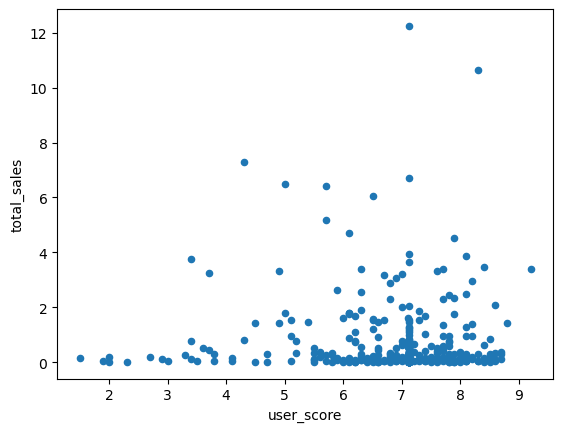

In [13]:
ps4_data.plot(x='user_score', y='total_sales', kind='scatter')

ps4_data[['user_score', 'total_sales']].corr()

Com base no coeficiente de correlação é possível afirmar que não há correlação entre avaliações de usuários e vendas totais. O jogo mais vendido foi avaliado em torno de 7.

,critic_score,total_sales
critic_score,1.000000,0.351672
total_sales,0.351672,1.000000


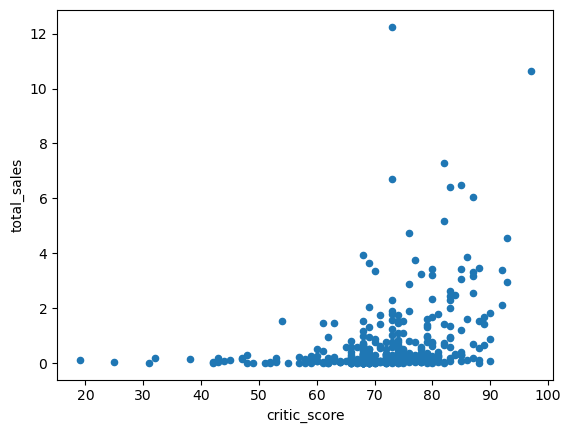

In [14]:
ps4_data.plot(x='critic_score', y='total_sales', kind='scatter')

ps4_data[['critic_score', 'total_sales']].corr()

Com base no coeficiente de correlação é possível afirmar que há uma pequena correlação entre a avaliação crítica e as vendas totais. O jogo mais mais vendido foi avaliado em torno de 73.

Isso mostra que alta qualidade não garante sucesso em vendas para os jogos do PS4.

### Comparando as vendas de jogos em plataformas diferentes

In [15]:
recent_subset = recent_data.query('platform == "PS4" | platform == "XOne" | platform == "3DS"')

name_counts = recent_subset.name.value_counts()

games = recent_subset[recent_subset['name'].isin(name_counts.index[name_counts.gt(1)])] #pega os valores maiores que um no name_counts
games = games.sort_values('name')

games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
12863,7 Days to Die,XOne,2016,Action,0.03,0.02,0.00,0.00,35.0,5.2,M,0.05
9197,7 Days to Die,PS4,2016,Action,0.04,0.08,0.00,0.02,45.0,5.9,M,0.12
14940,Agatha Christie's The ABC Murders,PS4,2016,Adventure,0.01,0.01,0.00,0.00,67.0,6.2,T,0.02
16322,Agatha Christie's The ABC Murders,XOne,2016,Adventure,0.01,0.00,0.00,0.00,66.0,7.5,E,0.01
11243,Assassin's Creed Chronicles,PS4,2016,Action,0.01,0.05,0.01,0.01,68.0,6.1,T,0.07


In [16]:
games.groupby('platform').count()

ps4_x1 = games[(games['platform'] == 'PS4') | (games['platform'] == 'XOne')]
ps4_x1.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
12863,7 Days to Die,XOne,2016,Action,0.03,0.02,0.00,0.00,35.0,5.2,M,0.05
9197,7 Days to Die,PS4,2016,Action,0.04,0.08,0.00,0.02,45.0,5.9,M,0.12
14940,Agatha Christie's The ABC Murders,PS4,2016,Adventure,0.01,0.01,0.00,0.00,67.0,6.2,T,0.02
16322,Agatha Christie's The ABC Murders,XOne,2016,Adventure,0.01,0.00,0.00,0.00,66.0,7.5,E,0.01
11243,Assassin's Creed Chronicles,PS4,2016,Action,0.01,0.05,0.01,0.01,68.0,6.1,T,0.07


In [17]:
game_sales = ps4_x1.pivot_table(index='name', columns='platform', values='total_sales')

game_sales.head()

platform,PS4,XOne
name,,
7 Days to Die,0.12,0.05
Agatha Christie's The ABC Murders,0.02,0.01
Assassin's Creed Chronicles,0.07,0.01
Assassin's Creed The Ezio Collection,0.17,0.07
Assetto Corsa,0.05,0.01


Notamos acima a diferença entre as vendas dos jogos em cada console.

In [18]:
game_sales['difference'] = game_sales['PS4'] - game_sales['XOne']

mean = game_sales['difference'].mean()
median = game_sales['difference'].median()

print('A diferença média entre as vendas do PS4 e do Xbox One é:', mean)
print('A diferença mediana entre as vendas do PS4 e do Xbox One é:', median)

A diferença média entre as vendas do PS4 e do Xbox One é: 0.27250000000000013
A diferença mediana entre as vendas do PS4 e do Xbox One é: 0.07499999999999998


Os jogos crossplay entre o PS4 e o Xbox One são minimamente diferentes, sendo os jogos vendidos no PS4 com uma média aproximada de $272.500 a mais em vendas totais do que no Xbox One.

Pela mediana é notável que a média foi elevada por algumas vendas excepcionais, ou seja, o PS4 têm outliers maiores.

Com base nisso a melhor plataforma de escolha é o PS4.

### Determinando o gênero de jogo mais lucrativo

In [19]:
genre_data = recent_data.groupby('genre')
genre_data.agg({'total_sales':'sum'}).sort_values('total_sales', ascending=False)

,total_sales
genre,
Shooter,33.20
Action,27.04
Sports,20.47
Role-Playing,16.78
Fighting,3.93
Adventure,3.45
Platform,2.79
Racing,2.51
Misc,2.46


Observando a tabela vemos que os gêneros mais lucrativos são `Shooter`, `Action`, `Sports` e `Role-Playing`, portanto, são os melhores na hora de fazer um jogo.

Para melhor compreensão, verificaremos a distribuição das vendas totais por gênero para ter certeza que os dados anteriores estão corretos.

<AxesSubplot:title={'center':'total_sales'}, xlabel='genre'>

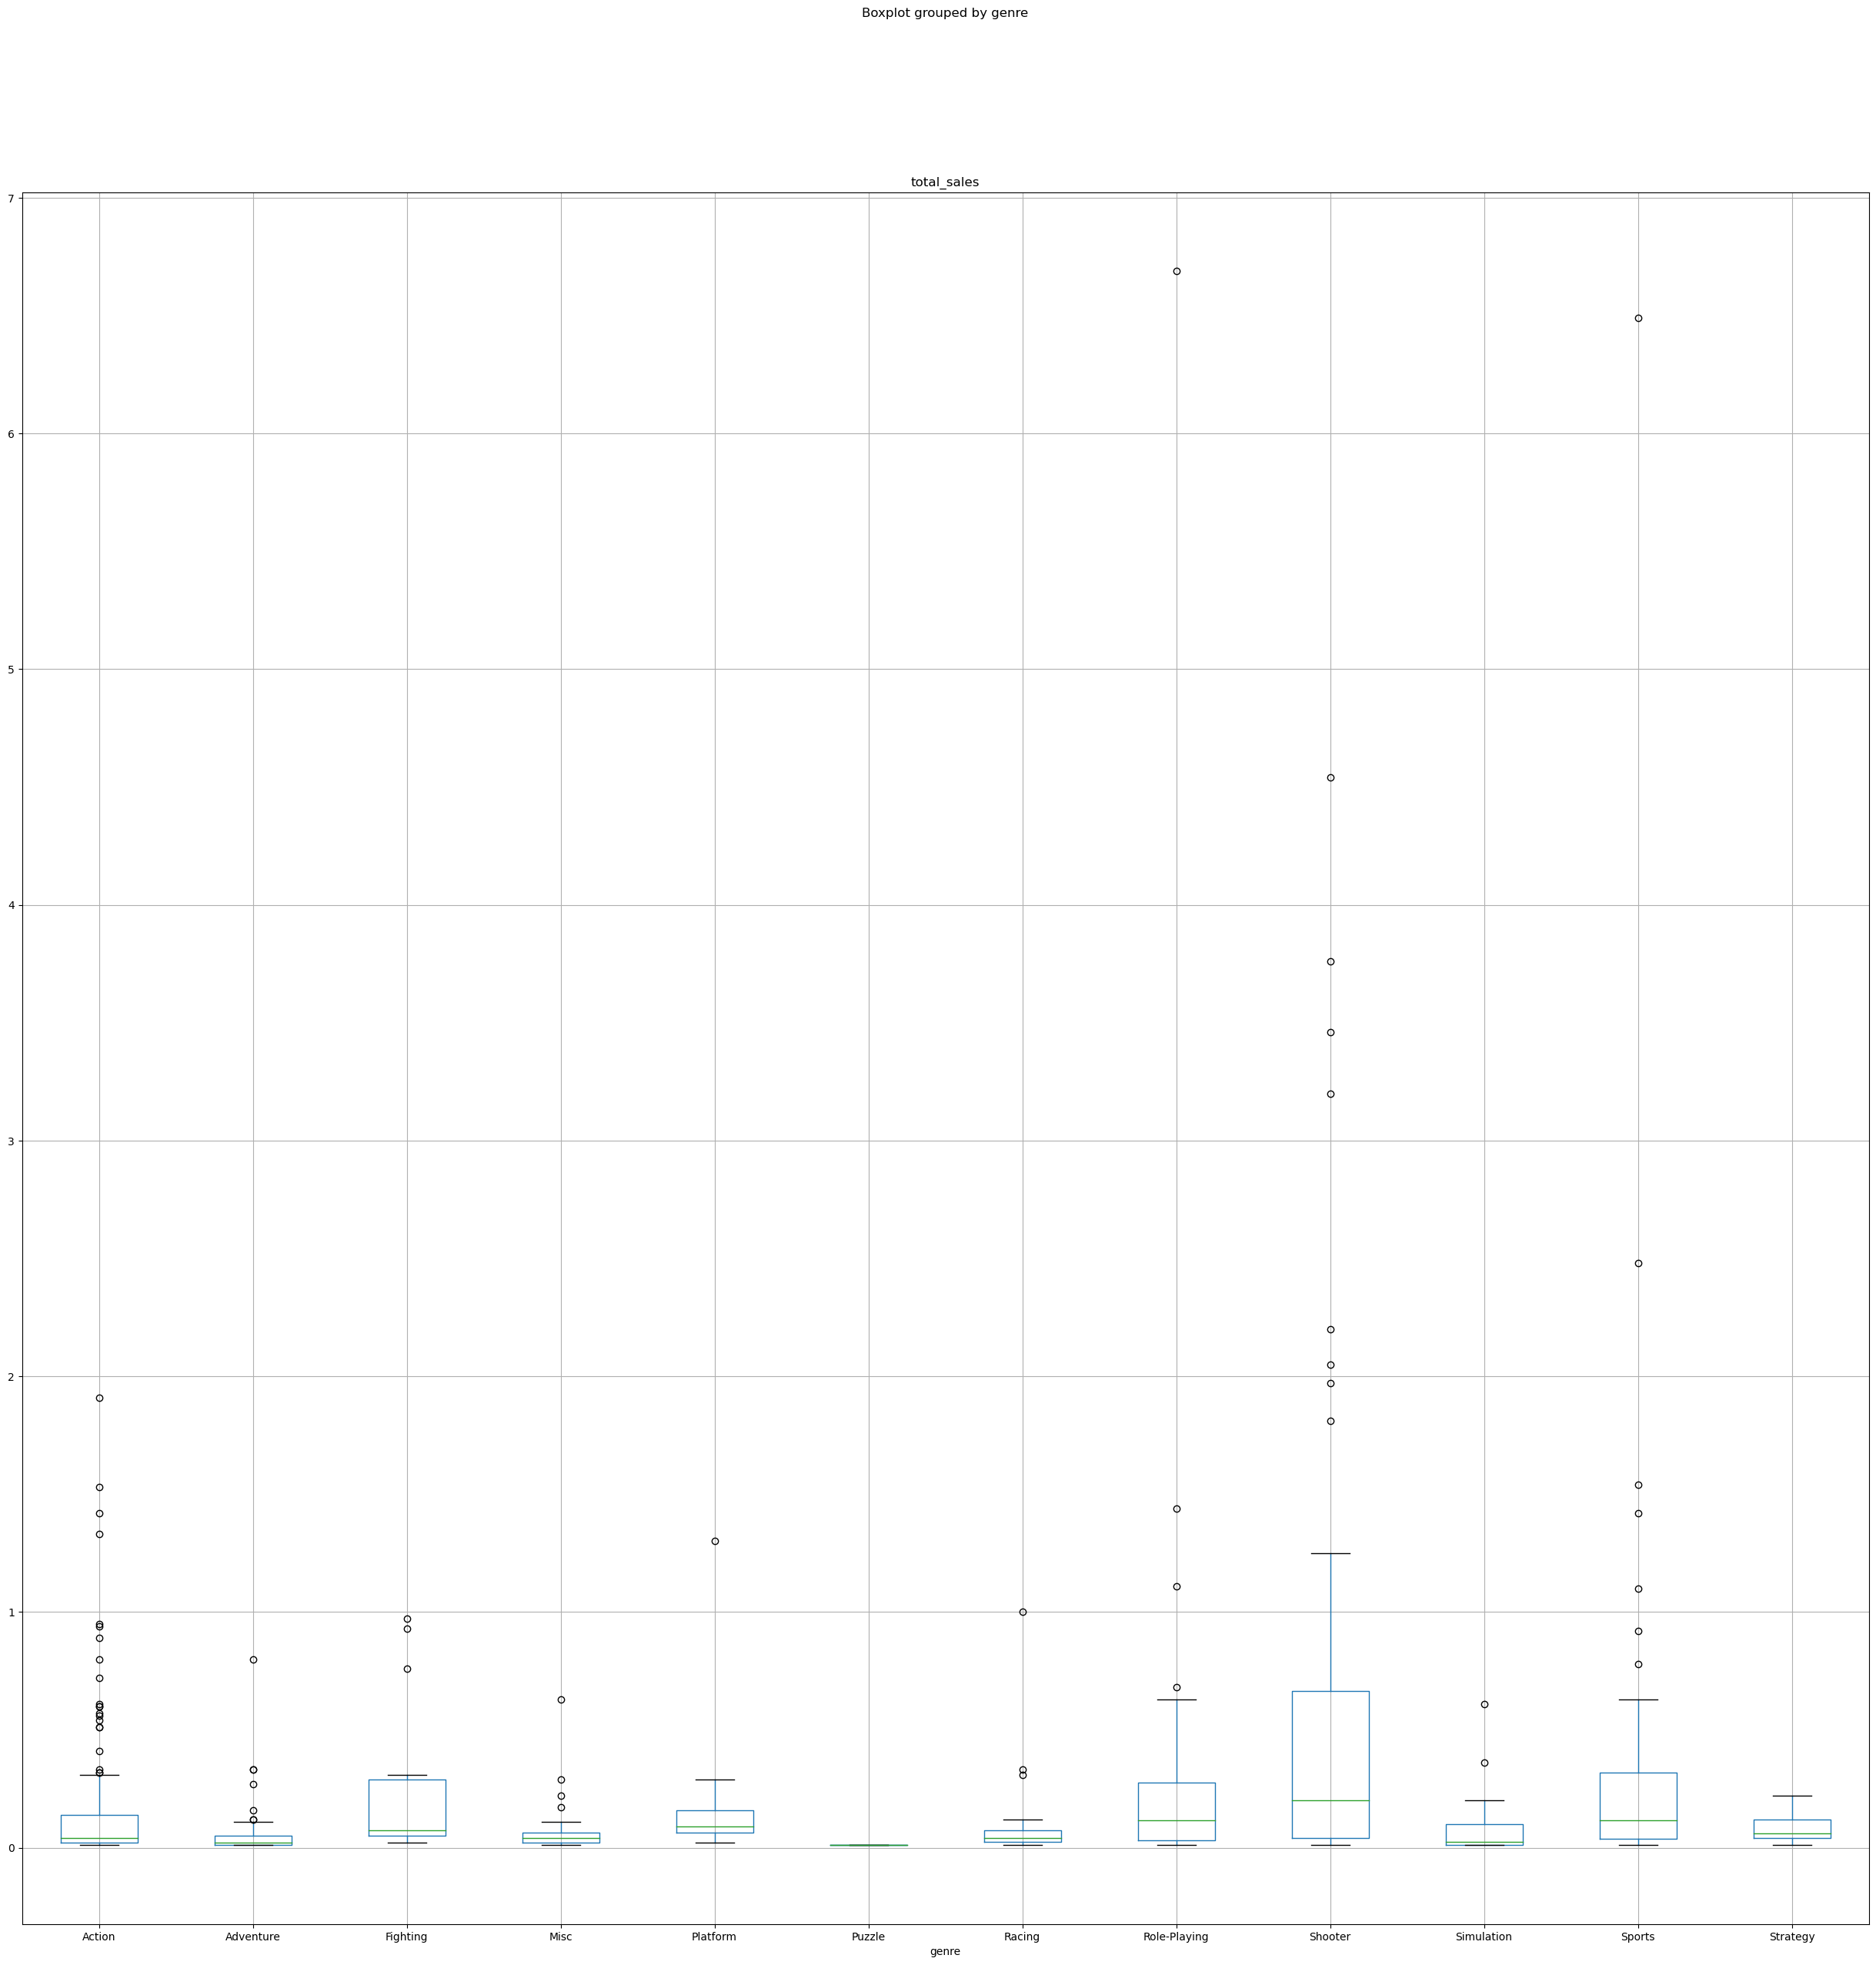

In [20]:
recent_data[['genre','total_sales']].boxplot(by='genre', column='total_sales', figsize=(30,30))

<AxesSubplot:title={'center':'total_sales'}, xlabel='genre'>

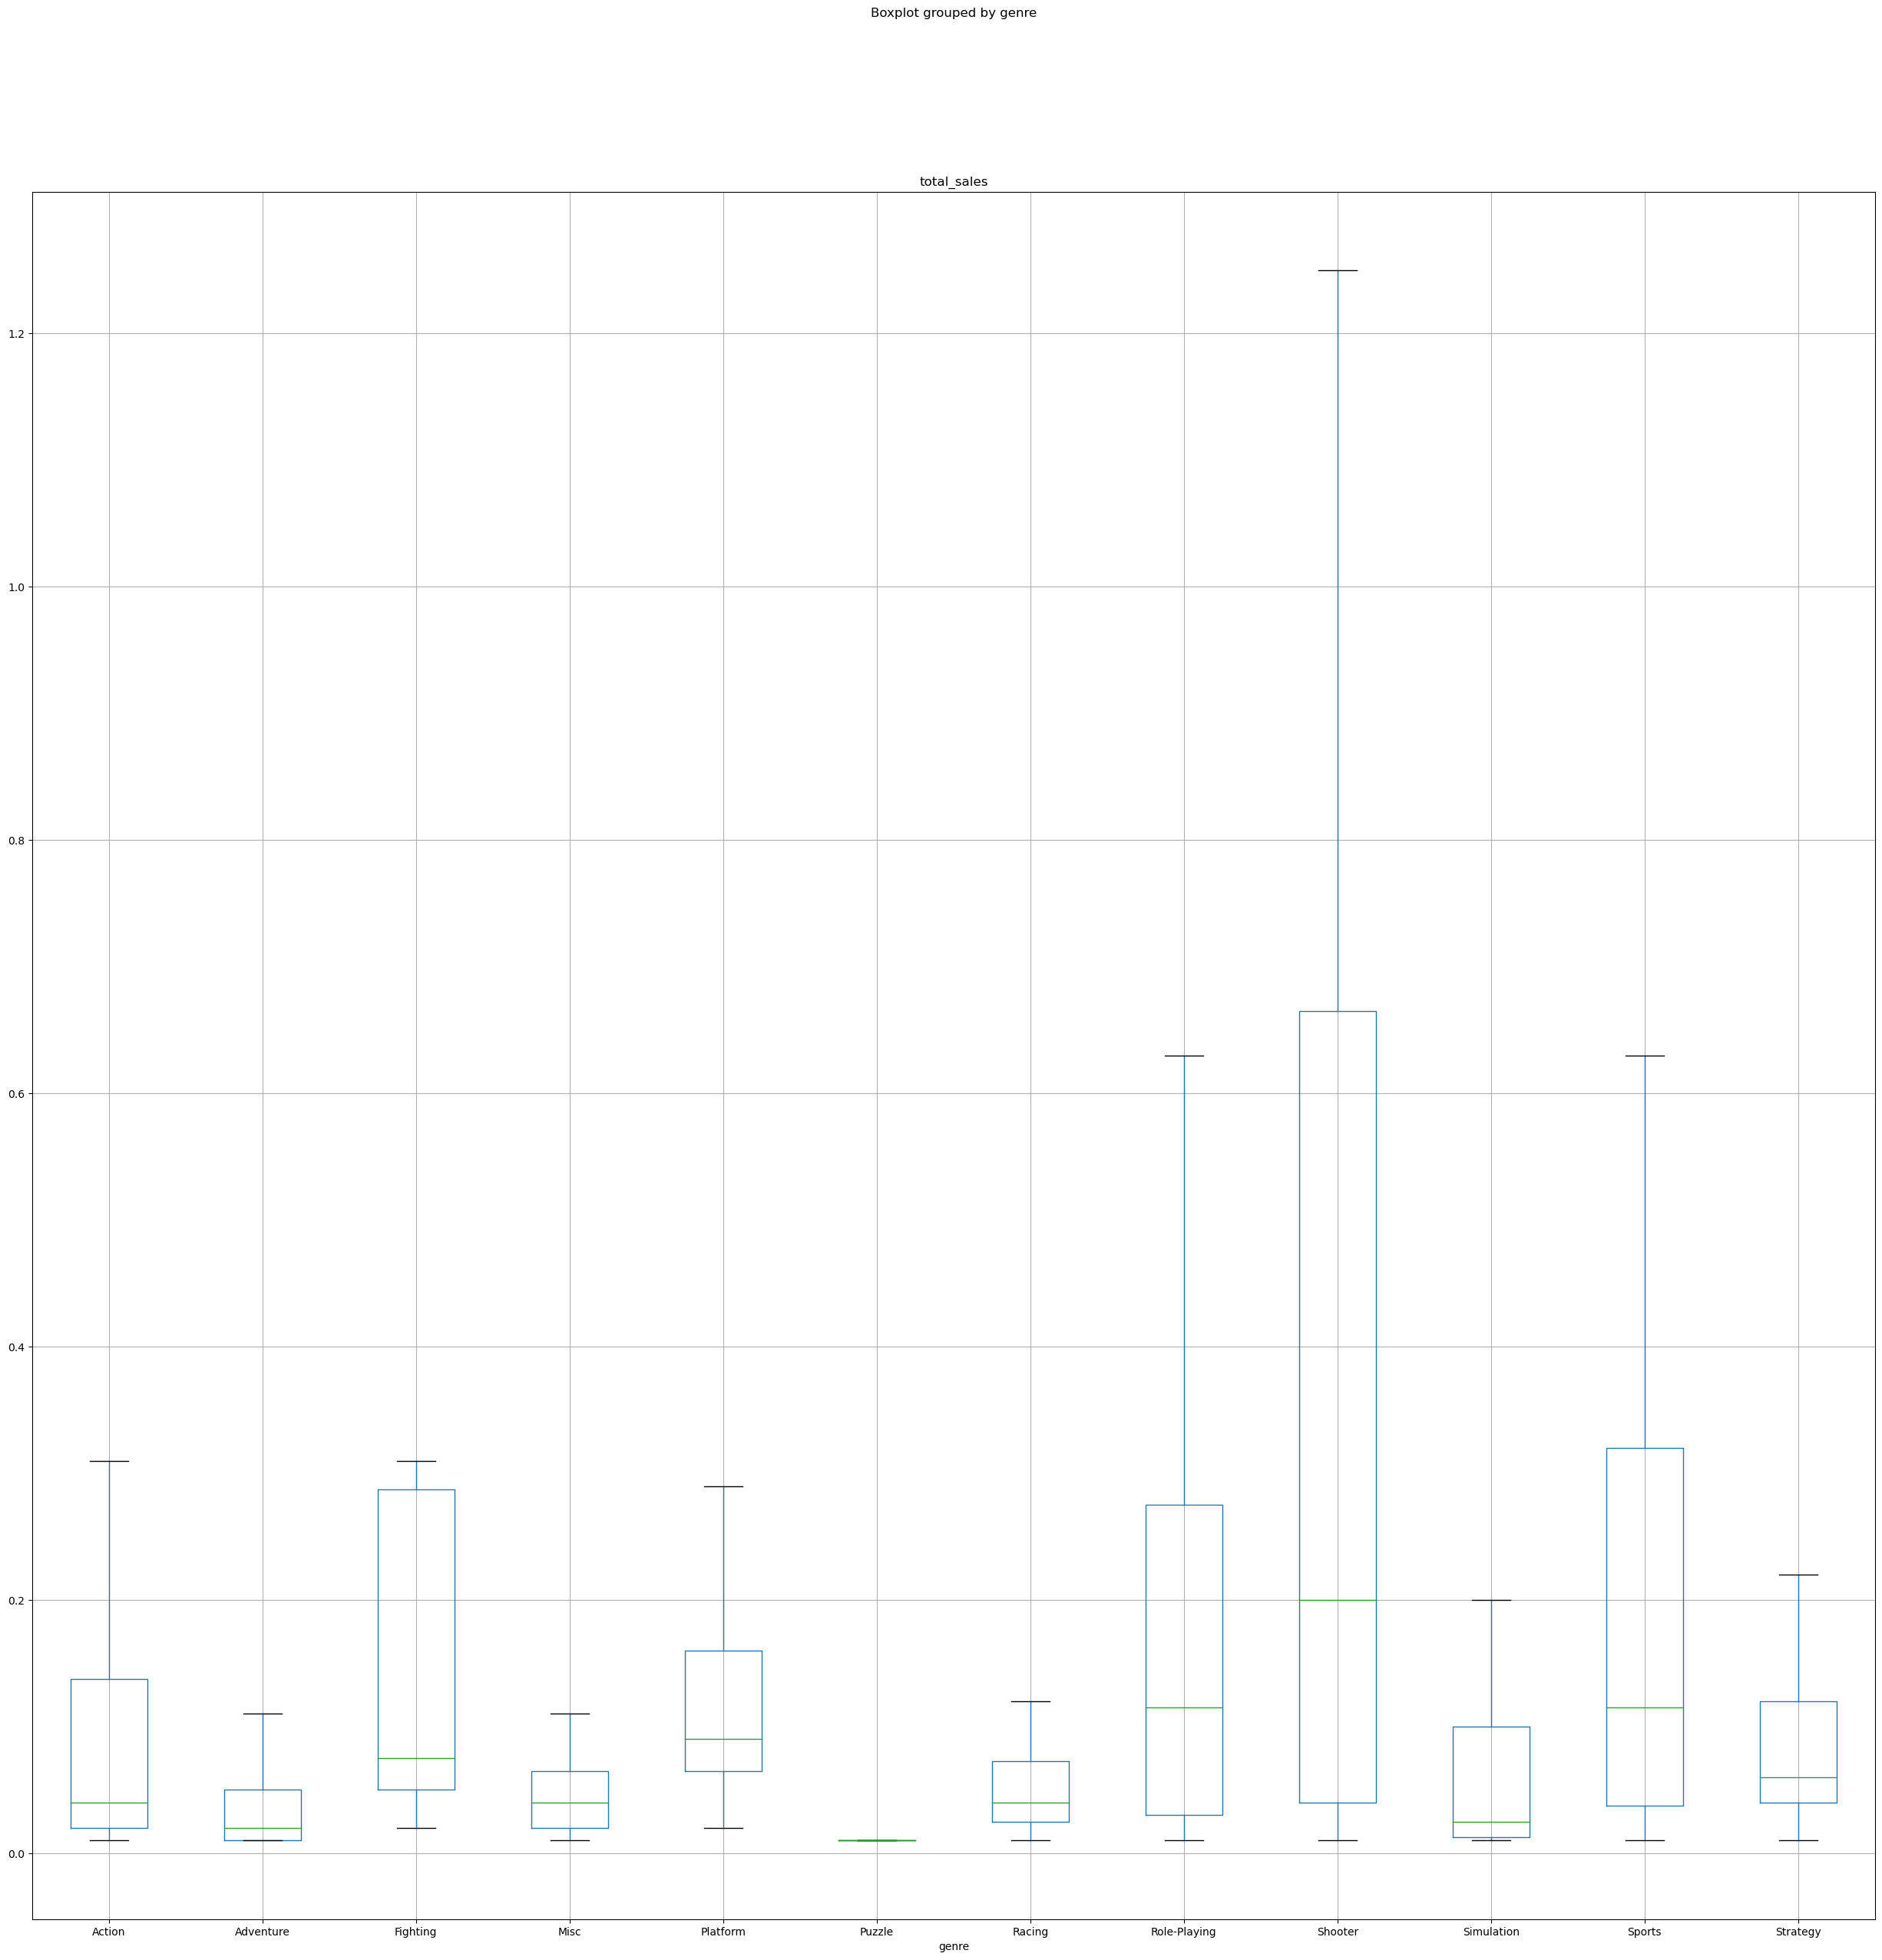

In [21]:
recent_data[['genre','total_sales']].boxplot(by='genre', column='total_sales', figsize=(30,30), showfliers=False)

Assim, confirmamos, portanto, que os jogos `Shooter`, `Action`, `Sports` e `Role-Playing` são altamente lucrativos. Ressalto para o gênero `Shooter` que tem a média mais alta em torno de 200.000 dólares em vendas e tem o maior IQR entre todos os gêneros de jogos e o maior limite entre os mesmos. No entanto, os maiores outliers estão nos gêneros `Role-Playing` e `Sports`.

### Definindo o perfil de usuário por região

#### Por gênero

In [22]:
top_genres = recent_data.groupby('genre').agg({'total_sales':'sum'}).sort_values('total_sales', ascending=False).reset_index()

top_5_genres_list = top_genres['genre'][0:5].to_list()
top_5_genres = recent_data.query('genre in @top_5_genres_list')
top_5_genres_grouped = top_5_genres.groupby('genre').agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum', 'total_sales':'sum'})

top_5_genres_grouped

,na_sales,eu_sales,jp_sales,total_sales
genre,,,,
Action,9.29,10.68,7.07,27.04
Fighting,1.84,1.34,0.75,3.93
Role-Playing,5.89,4.28,6.61,16.78
Shooter,16.24,15.90,1.06,33.20
Sports,7.54,12.01,0.92,20.47


Podemos ver as diferenças entre as vendas de jogos por gênero em cada região.
- `JP` têm as maiores vendas em `RPG`;
- `EU` têm as maiores vendas em jogos `Action` e `Sports`;
- `NA` têm as maiores vendas em jogos `Shooter` e `Fighting`.

#### Por plataforma

In [23]:
top_platforms = recent_data.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales', ascending=False).reset_index()

top_5_list = top_platforms['platform'][0:5].to_list()
top_5_platforms = recent_data.query('platform in @top_5_list')
top_5_platforms_grouped = top_5_platforms.groupby('platform').agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum', 'total_sales':'sum'})

top_5_platforms_grouped

,na_sales,eu_sales,jp_sales,total_sales
platform,,,,
3DS,4.14,2.33,8.03,14.50
PC,1.36,3.53,0.00,4.89
PS4,21.49,31.78,5.74,59.01
WiiU,2.10,1.48,0.67,4.25
XOne,14.27,9.63,0.01,23.91


Podemos ver as diferenças entre as vendas de jogos por plataforma em cada região.
- `JP` têm as maiores vendas em jogos no `3DS`;
- `EU` têm as maiores vendas em jogos no `PC` e `PS4`;
- `NA` têm as maiores vendas em jogos no `WiiU` e `Xbox One`.

#### Pela classificação ESRB

In [24]:
esrb_data = recent_data.groupby('rating').agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum', 'total_sales':'sum'})
esrb_data

,na_sales,eu_sales,jp_sales,total_sales
rating,,,,
E,9.36,16.06,3.94,29.36
E10+,3.81,3.81,0.45,8.07
M,16.78,17.61,1.22,35.61
T,14.98,13.74,13.70,42.42


Podemos ver as diferenças entre as vendas de jogos pela classificação ESRB em cada região.
- Jogos de classificação `E` vendem relativamente iguais em cada região;
- Jogos de classificação `E10+` vendem melhor em `EU` e `NA` comparado com `JP`;
- Jogos de classificação `M` vendem pouquissímo no `JP`;
- Jogos de classificação `T` vendem melhor em `EU` e `NA`.

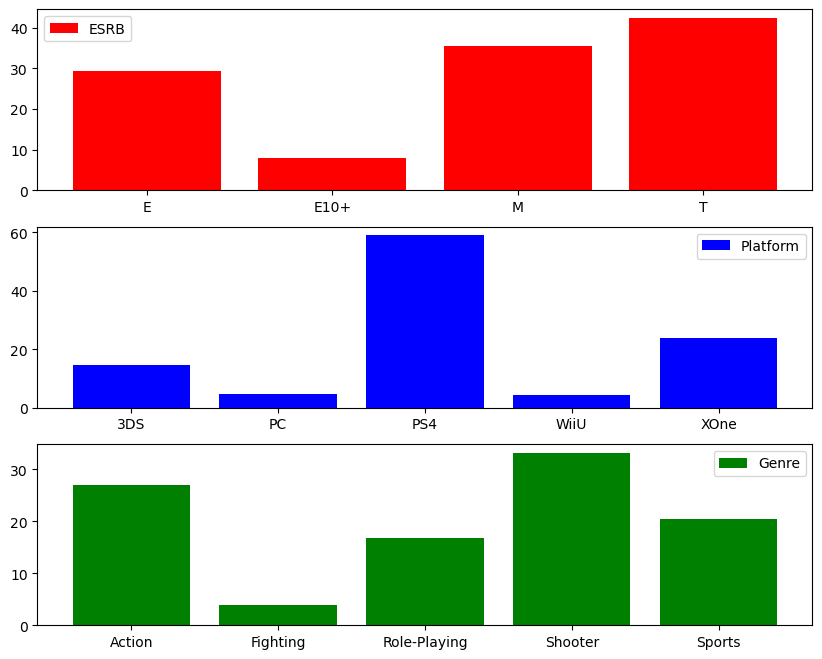

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(10,8))

rating = ['E', 'E10+', 'M', 'T']
platform = ['3DS', 'PC', 'PS4', 'WiiU', 'XOne']
genre = ['Action', 'Fighting', 'Role-Playing', 'Shooter', 'Sports']

ax[0].bar(rating, esrb_data['total_sales'], color="red")
ax[0].legend(["ESRB"])
ax[1].bar(platform, top_5_platforms_grouped['total_sales'], color="blue")
ax[1].legend(["Platform"])
ax[2].bar(genre, top_5_genres_grouped['total_sales'], color="green")
ax[2].legend(["Genre"])

plt.show()

### Testando hipóteses

#### Hipótese 1

A primeira hipótese nula será que as avaliações médias dos usuários das plataformas Xbox One e PC não diferem. A alternativa atesta que as avaliações médias dos usuários das plataformas Xbox One e PC diferem.

In [26]:
alpha = 0.5

results = st.ttest_ind(ps4_data['user_score'], xone_data['user_score'])
print('p-value:', results.pvalue)

if(results.pvalue < alpha):
    print('A hipótese nula foi rejeitada')
else:
    print('A hipótese nula não pode ser rejeitada')

p-value: 0.0432994765139477
A hipótese nula foi rejeitada


Com base no teste, há evidências estatisticamente significativas de que as avaliações médias dos usuários das plataformas Xbox One e PC diferem.

### Hipótese 2

A segunda hipótese nula será que as avaliações médias dos usuários para os gêneros `Action` e `Sports` não diferem. A hipótese alternativa atesta que as avaliações médias dos usuários para os gêneros `Action` e `Sports` são diferentes.

In [27]:
action = recent_data.query('genre == "Action"')['user_score']
sports = recent_data.query('genre == "Sports"')['user_score']

alpha = 0.05

results = st.ttest_ind(action, sports)
print('p-value:', results.pvalue)

if(results.pvalue < alpha):
    print('A hipótese nula foi rejeitada')
else:
    print('A hipótese nula não pode ser rejeitada')

p-value: 5.602970965139628e-07
A hipótese nula foi rejeitada


Com base no teste, há evidências estatisticamente significativas de que as avaliações médias dos usuários para os gêneros `Action` e `Sports` são diferentes.

## Conclusão

Fundamentado nos dados coletados e analisados, foi determinado que existem muitos fatores diferentes que contribuem para o sucesso de um jogo e que a popularidade de um jogo desenvolvido varia drasticamente com base em muitas variáveis diferentes, incluindo gênero, console e e o país em que o jogo foi lançado. Até mesmo a classificação ESRB tem um impacto sobre a popularidade de um jogo entre diferentes países.

Independentemente de haver outros fatores contribuintes no sucesso de um jogo, podemos utilizar dados para aumentar o potencial de sucesso do jogo. Ademais, desde que um jogo seja lançado em um dos principais gêneros, a probabilidade de grandes lucros aumenta. Como visto na distribuição dos boxplots, existem muitos outliers de grande variação de lucros nos principais gêneros.